In [9]:
import numpy as np
import polars as pl
import marshal, json
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.patches as patches
from matplotlib import cm
import matplotlib
import json, math
from operator import sub
from matplotlib import colors
import scipy.stats
from IPython.display import set_matplotlib_formats
from IPython.display import Image
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
    'font.family': 'serif',
    "font.serif": 'Times',
    'font.size': 12,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.latex.preamble': r'\usepackage{amsmath}\usepackage{amssymb}'
})

v = 506

n = 100
i = 120
q = 200
num_runs = 20

R = 509.8
rho = 12 / 1e6

In [10]:
def get_aspect(ax):
    # Total figure size
    figW, figH = ax.get_figure().get_size_inches()
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    # Ratio of display units
    disp_ratio = (figH * h) / (figW * w)
    # Ratio of data units
    # Negative over negative because of the order of subtraction
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

    return disp_ratio / data_ratio

In [11]:
def get_forwarding_options(n, i, q, mg = 100, pL = 0):
    df = pl.read_csv(f'../res/v{v}/fwd_options_rdf_n{n}_i{i}_q{q}_mg{mg}_pL{pL}_r0.csv')
    df = df.with_columns(
        pl.concat_str([pl.col('seqNo'), pl.lit('-1')]).alias("seqNo_with_run_id")
    )
    for r in range(1, num_runs):
        try:
            run_df = pl.read_csv(f'../res/v{v}/fwd_options_rdf_n{n}_i{i}_q{q}_mg{mg}_pL{pL}_r{r}.csv')
            run_df = run_df.with_columns(
                pl.concat_str([pl.col('seqNo'), pl.lit(f'-{r}')]).alias("seqNo_with_run_id")
            )
            df = pl.concat([df, run_df])
        except:
            pass
        
    return df


In [12]:
def get_packet_loss(n, i, q, mg = 100, pL = 0):
    loss_rates = []
    for r in range(0, num_runs):
        try:
            with open(f'../res/v{v}_parsed/summary_kpi_rdf_n{n}_i{i}_q{q}_mg{mg}_pL{pL}_r{r}.json', 'r') as f:
                data = json.load(f)
                if data['avg_loss_rate'] > 0:
                    loss_rates.append(data['avg_loss_rate'])
        except:
            pass
        
    return np.mean(loss_rates)

In [13]:
def get_coding_gain_distribution(n, i, q, mg = 100, pL = 0, p_e_override = None):

    p_e = p_e_override if p_e_override != None else get_packet_loss(n,i,q,mg, pL)
    p_s = 1 -p_e

    print('LOSS',p_e)

    # option -> O
    # forwarded_from -> F
    # forwarder -> E
    df = get_forwarding_options(n, i, q, mg, pL)
    d_FO = np.sqrt(np.power(df['forwarded_from_x'] - df['option_x'], 2) + np.power(df['forwarded_from_y'] - df['option_y'], 2))
    d_EO = np.sqrt(np.power(df['forwarder_x'] - df['option_x'], 2) + np.power(df['forwarder_y'] - df['option_y'], 2))
    d_FE = np.sqrt(np.power(df['forwarder_x'] - df['forwarded_from_x'], 2) + np.power(df['forwarder_y'] - df['forwarded_from_y'], 2))

    alpha_FO = np.arccos(d_FO / (2*R))
    alpha_EO = np.arccos(d_EO / (2*R))
    alpha_FE = np.arccos(d_FE / (2*R))

    overlap_FO = 2 * alpha_FO * R**2 - d_FO * R * np.sin(alpha_FO)
    overlap_EO = 2 * alpha_EO * R**2 - d_EO * R * np.sin(alpha_EO)
    overlap_FE = 2 * alpha_FE * R**2 - d_FE * R * np.sin(alpha_FE)

    A = math.pi * R**2

    A_0 = A - overlap_FE
    A_1 = overlap_FE - overlap_FO
    A_2 = overlap_EO - overlap_FO
    A_3 = overlap_FO

    xR = p_s * rho * (A_0 + (A_1 + A_3) * p_e)

    xR_NC = p_s * rho * ((A_1 + A_2) * p_s + A_3 * p_e * p_s)

    df = df.with_columns([pl.lit(xR).alias('xR'), pl.lit(xR_NC).alias('xR_NC'), pl.lit(xR_NC- xR).alias('delta_xR')])
    delta_xR_max = df.groupby(['seqNo_with_run_id', 'forwarder']).agg(pl.col('delta_xR').max())
    gains_NC = delta_xR_max['delta_xR'].to_numpy()


    return xR.to_numpy(), gains_NC


In [14]:
xR_0, gains_NC_0 = get_coding_gain_distribution(100, 120, 200, 100, 0, 0.0)
xR_10, gains_NC_10 = get_coding_gain_distribution(100, 120, 200, 100, 0, 0.1)
xR_20, gains_NC_20 = get_coding_gain_distribution(100, 120, 200, 100, 0, 0.2)
xR_40, gains_NC_40 = get_coding_gain_distribution(100, 120, 200, 100, 0, 0.4)
xR_50, gains_NC_50 = get_coding_gain_distribution(100, 120, 200, 100, 0, 0.5)
xR, gains_NC = get_coding_gain_distribution(100, 120, 200)

LOSS 0.0


/home/fu/.pyenv/versions/3.11.1/lib/python3.11/site-packages/polars/series/series.py:1474: RuntimeWarning: invalid value encountered in arccos
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))
/tmp/ipykernel_943388/1570361513.py:36: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  delta_xR_max = df.groupby(['seqNo_with_run_id', 'forwarder']).agg(pl.col('delta_xR').max())


LOSS 0.1
LOSS 0.2
LOSS 0.4
LOSS 0.5
LOSS 0.32221023765710183


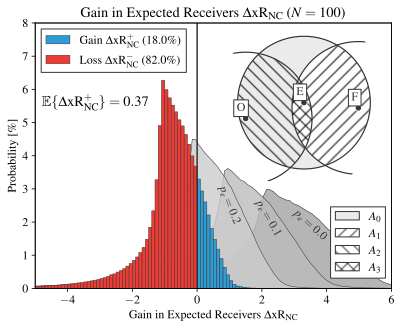

In [20]:
red = '#f03a34'
blue = '#2e9dd6'

fig, ax = plt.subplots()
gain_share = len(gains_NC[gains_NC > 0]) / len(gains_NC)
step = 0.1

grays = [
    '#a3a3a3',
    '#bbbbbb',
    '#cccccc',
    '#cdcdcd',
    '#dddddd'
]

text_pos = [
    (3.5, 1.9),
    (2.2, 2.1),
    (1.0, 2.5),
    (0.0, 0.0),
    (0.0, 0.0)
]

rotations=[ -42, -60, -68, 0, 0]

cnts, bin_edges = np.histogram(gains_NC, bins=np.arange(-10, 10, step))
bar_heights = cnts / np.sum(cnts) * 100
bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2
negative_bin_centers = bin_centers[bin_centers < 0]
negative_bar_heights = bar_heights[bin_centers < 0]
positive_bin_centers = bin_centers[bin_centers >= 0]
positive_bar_heights = bar_heights[bin_centers >= 0]

for idx, g in enumerate([gains_NC_0, gains_NC_10, gains_NC_20]):
    cnts, bin_edges = np.histogram(g, bins=np.arange(-10, 10, step))
    bar_heights = cnts / np.sum(cnts) * 100

    ax.fill(bin_centers, bar_heights, color=grays[idx], lw = 0.5, zorder = 1, alpha=0.8)
    ax.plot(bin_centers, bar_heights, color='#333', lw = 0.5, zorder = 1)
    ax.text(text_pos[idx][0], text_pos[idx][1], f'$p_e={idx/10:.1f}$', color='#333', rotation=rotations[idx], va="center", ha="center")

ax.bar(positive_bin_centers, positive_bar_heights, lw=0.5, ec="#333", color=blue, width=step, label=f'Gain $\Delta{{\mathrm{{xR}}}}_\mathrm{{NC}}^{{+}}$ ({gain_share*100:.1f}\%)')
ax.bar(negative_bin_centers, negative_bar_heights, lw=0.5, ec="#333", width=step, color=red, label=f'Loss $\Delta{{\mathrm{{xR}}}}_\mathrm{{NC}}^{{-}}$ ({(1-gain_share)*100:.1f}\%)')


# {np.mean(gains_NC[gains_NC > 0]):.2f}
ax.set_ylabel('Probability [\%]')
ax.set_xlabel('Gain in Expected Receivers $\Delta{\mathrm{xR}}_\mathrm{NC}$')

plt.title('Gain in Expected Receivers $\Delta{\mathrm{xR}}_\mathrm{NC}$ ($N=100$)')

exp_gain = np.mean(gains_NC[gains_NC > 0])
ax.text(-4.8, 5.5, f'$\mathbb{{E}} \{{\Delta{{\mathrm{{xR}}}}_\mathrm{{NC}}^{{+}} \}}= {exp_gain:.2f}$', fontsize='large')
leg = ax.legend(fancybox=False, framealpha=1.0, loc="upper left")
leg.get_frame().set_edgecolor('#333')


# Plot Schematic

x_min = -5
x_max = 6
y_min = 0
y_max = 8

ax.plot([0,0],[0, y_max], color='#333')

ax.set_ylim([y_min, y_max])
ax.set_xlim([x_min, x_max])


aspect = get_aspect(ax)
center = (x_max * 0.55, y_max * 0.7)
height = 4
width = height * aspect
stretch = 1.3
mask = matplotlib.patches.Ellipse(center, width=width* stretch, height=height* stretch, fill=False, lw=0, clip_on=False)
ax.add_patch(mask)

circle = matplotlib.patches.Ellipse(center, width=width, height=height, fill=False, lw=1.2, ec='#333', clip_on=False, zorder=20)
ax.add_patch(circle)
circleP = matplotlib.patches.Ellipse(center, width=width, height=height, fill=True, fc='#ebebeb', lw=0, clip_on=False)
ax.add_patch(circleP)

# center_F = (x_max * 0.88, y_max * 0.58)
center_F = (center[0] + x_max * 0.28, center[1] - y_max * 0.02)
circle_F = matplotlib.patches.Ellipse(center_F, width=width, height=height, fill=False, lw=1.2, ec='#333', clip_on=True, clip_path=mask, zorder=10)
ax.add_patch(circle_F)
circle_FP = matplotlib.patches.Ellipse(center_F, width=width, height=height, fill=True, fc="#fff", lw=0, hatch="//", clip_on=True, clip_path=circle)
ax.add_patch(circle_FP)

# center_O = (x_max * 0.3, y_max * 0.54)
center_O = (center[0] - x_max * 0.3, center[1] - y_max * 0.06)
circle_O = matplotlib.patches.Ellipse(center_O, width=width, height=height, fill=False, lw=1.2, ec='#333', clip_path=mask, zorder=10)
ax.add_patch(circle_O)
circle_OP = matplotlib.patches.Ellipse(center_O, width=width, height=height, fill=False, lw=0, hatch="\\\\", clip_path=circle)
ax.add_patch(circle_OP)

s_OF = matplotlib.patches.Ellipse(center_O, width=width, height=height, fill=True, hatch="XX", fc="#fff", clip_path=circle_F)
ax.add_patch(s_OF)

x=[center[0], center_F[0], center_O[0]]
y=[center[1], center_F[1], center_O[1]]
ax.scatter(x, y, s=40, color='#fff', zorder=19)
ax.scatter(x, y, s=20, color='#333', zorder=20)

x_offset = 0.01
y_offset = 0.15
ax.text(center[0] - x_offset, center[1]+ y_offset,'E', ha='right', va='bottom', color='#333', bbox=dict(pad=3, fc='#fff', lw=1, color='#333', zorder=21), zorder=21)
ax.text(x[1] - x_offset, y[1]+ y_offset,'F', ha='right', va='bottom', color='#333', bbox=dict(pad=3, fc='#fff', lw=1, color='#333', zorder=21), zorder=21)
ax.text(x[2] - x_offset, y[2]+ y_offset,'O', ha='right', va='bottom', color='#333', bbox=dict(pad=3, fc='#fff', lw=1, color='#333', zorder=21), zorder=21)


ax2 = ax.twinx()
ax2.get_yaxis().set_visible(False)
ax2.bar([-11],[-11], ec='#333', color='#ebebeb', label="$A_0$")
ax2.bar([-11],[-11], ec='#333', color='#fff', hatch="//", label="$A_1$")
ax2.bar([-11],[-11], ec='#333', color='#fff', hatch="\\\\", label="$A_2$")
ax2.bar([-11],[-11], ec='#333', color='#fff', hatch="XX", label="$A_3$")
leg = ax2.legend(fancybox=False, framealpha=1.0, loc="upper right", bbox_to_anchor=(1, 0.33))
leg.get_frame().set_edgecolor('#333')


fig.savefig(f"../figures/delta_xR_NC_n{n}_i{i}_q{q}_v2.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/delta_xR_NC_n{n}_i{i}_q{q}_v2.png", dpi=500, bbox_inches='tight', pad_inches=0.01)
plt.show()
